In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as st
from scipy import optimize
import matplotlib.pylab as plt

import theano.tensor as tt
import theano

plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Laplace approximation in PyMC3

Here first try to port a [similar Stan example](http://discourse.mc-stan.org/t/algebraic-sovler-problems-laplace-approximation-in-stan/2172)
- TL;dr summary
    - http://discourse.mc-stan.org/t/algebraic-sovler-problems-laplace-approximation-in-stan/2172/37  
    
There are also some previous efforts
- Laplace approximation in PyMC3
    - https://healthyalgorithms.com/2015/06/22/laplace-approximation-in-python-another-cool-trick-with-pymc3/
    - https://healthyalgorithms.com/2015/07/10/laplace-approximation-in-pymc3-revisited/


## Setup data and fit with NUTS
Make sure there is no funny business here

In [2]:
N, M, sigma = 100, 10, 2.
index = np.random.randint(0, M, size=N)
X = np.random.normal(0, sigma, size=M)
Y = np.random.poisson(np.exp(X[index]))

In [3]:
X

array([-3.05436009,  3.74201637, -1.675817  , -0.82189137,  0.22621059,
       -2.53367077,  2.04930452, -3.05034469,  1.61051805,  2.57326183])

In [4]:
with pm.Model() as m:
    sd = pm.HalfNormal('sd', 1.)
    group_mu = pm.Normal('g_mu', 0., sd, shape=M)
    obs = pm.Poisson('obs', tt.exp(group_mu[index]), observed=Y)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g_mu, sd]
100%|██████████| 2000/2000 [00:03<00:00, 514.48it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '8468' (I am process '8469')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8468' (I am process '8470')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8469' (I am process '8470')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_di

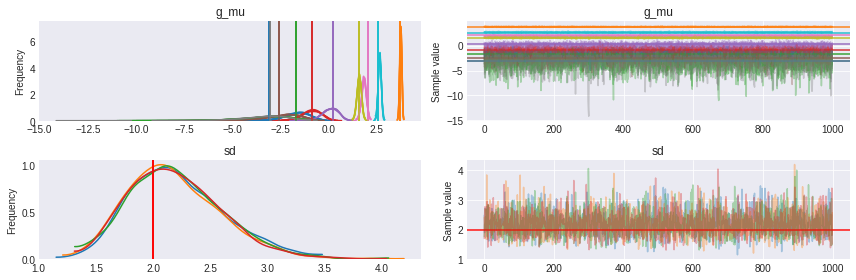

In [5]:
pm.traceplot(trace, lines={'sd': sigma, 'g_mu': X});

In [6]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
g_mu__0,-1.64,0.66,0.01,-2.93,-0.40,4765.00,1.0
g_mu__1,3.77,0.05,0.00,3.67,3.87,7291.89,1.0
g_mu__2,-3.29,1.35,0.02,-5.87,-0.93,3457.60,1.0
g_mu__3,-0.88,0.50,0.01,-1.87,0.05,5880.23,1.0
g_mu__4,0.10,0.41,0.01,-0.77,0.80,5615.75,1.0
g_mu__5,-2.30,0.89,0.01,-4.08,-0.72,4276.80,1.0
g_mu__6,1.86,0.13,0.00,1.60,2.11,5467.42,1.0
g_mu__7,-3.36,1.29,0.02,-5.87,-1.15,3712.24,1.0
g_mu__8,1.61,0.12,0.00,1.38,1.84,5813.43,1.0
g_mu__9,2.68,0.08,0.00,2.53,2.84,6716.89,1.0


## Direct port of Stan model

> Consider a model like this:
$$
\begin{align*} y &\sim p(y | x,\theta) \\ x \mid \theta &\sim N(0,Q(\theta)^{-1})\\ \theta &\sim \pi(\theta) \end{align*}
$$

> The most important thing to note is that, because $p(x,y,\theta) = p(x \mid y,\theta)p(\theta \mid y ) p(y)$ it follows that
$$
p(\theta \mid y ) = \frac{p(x,y,\theta)}{p(x \mid y, \theta) p(y)} \propto \frac{p(y\mid x,\theta)p(x \mid \theta) p(\theta)}{p(x \mid y, \theta)}.
$$

> This identity hold for every $x$. The only problem is that except in special cases (like a model with a Gaussianl likelihood), we don’t know $p(x \mid y, \theta)$.

> The trick that we use is to approximate the conditional $p(x \mid \theta,y)$ by a Gaussian that matches the location and curvature at the mode. To do this we need to find
$$
x^*(\theta) = \arg \max_x p(x \mid y,\theta)
$$ 

> and compute the Hessian of $p(x \mid y,\theta)$ at $x^*(\theta)$. A quick calculation shows that this Hessian is
$$
Q(\theta) + H(\theta),
$$

> where $H_{ij} = \frac{\partial^2}{\partial x_i \partial x_j} \log( p(x \mid y,\theta))$. The Gaussian approximation is then
$$
p(x \mid y,\theta) \approx N(x^*(\theta), (Q(\theta) + H(\theta))^{-1}).
$$

> We then use the above expression for $p(\theta \mid y)$ evaluating the RHS at $x=x^*(\theta)$ and get
$$
p(\theta \mid y) \propto \left(\frac{|Q(\theta)|}{|Q(\theta) + H(\theta)|}\right)^{1/2} \exp\left(-\frac{1}{2}x^*(\theta)^TQ(\theta)x^*(\theta) +\log p(y \mid x^*(\theta),\theta) \right)\pi(\theta).
$$

Data and transformed data:

```stan
data {
  int N;
  int M;
  int y[N];
  int<lower=1, upper=M> index[N];
}
```

```stan
transformed data {
  vector[M] xzero = rep_vector(0.0, M);
  real number_of_samples[M];
  int sums[M];
  for (j in 1:M) {
    sums[j] = 0;
    number_of_samples[j]=0.0;
  }
  for (i in 1:N) {
    sums[index[i]] += y[i];
    number_of_samples[index[i]] +=1.0;

  }

 // xzero = log((to_vector(sums) + 0.1) ./ to_vector(number_of_samples));
{ // Beware of empty categories!!!!!!
    int tmp = M;
    real summm=0.0;
    for (i in 1:M) {
      if(number_of_samples[i]==0){
        tmp = tmp-1;
      } else {
        summm = summm + sums[i]/number_of_samples[i];
      }
    }
    xzero = rep_vector(summm/tmp,M);
  }
}

```

In [7]:
# transformed data block
sums = np.zeros(M)
number_of_samples = np.zeros(M)
for i in range(N):
    sums[index[i]] += Y[i]
    number_of_samples[index[i]] += 1

# xzero = np.log((sums + 0.1) / number_of_samples)
tmp = M
summm=0.0
for i in range(M):
    if number_of_samples[i]==0:
        tmp = tmp-1
    else:
        summm = summm + sums[i]/number_of_samples[i]

xzero = np.repeat(summm/tmp, M)

```stan
functions {
  vector conditional_grad(vector x, vector sigma, real[] number_of_samples, int[] sums) {
    vector[dims(x)[1]] result;
    result = (to_vector(sums)-to_vector(number_of_samples).*exp(x)) - x/sigma[1]^2;
    return result;
  }
  vector conditional_neg_hessian(vector x,  real sigma, real[] number_of_samples) {
    vector[dims(x)[1]] result;
    result = to_vector(number_of_samples).*exp(x) + 1/sigma^2;
    return result;
  }
}
```

In [8]:
# functions block
def conditional_grad(x, sigma, number_of_samples, sums):
    return (sums - number_of_samples * tt.exp(x)) - x / sigma**2


def conditional_neg_hessian(x, sigma, number_of_samples):
    return number_of_samples * tt.exp(x) + 1 / sigma**2

### Implement algebra_solver

```stan
transformed parameters {
  vector[1] sigma_tmp;
  vector[M] conditional_mode;
  sigma_tmp[1] = sigma;
  conditional_mode = algebra_solver(conditional_grad, xzero, sigma_tmp, number_of_samples, sums );
}
```

In [9]:
# rewrite functions
# conditional_grad
def func(x, sigma):
    return sums - number_of_samples * np.exp(x) - x / sigma**2


# conditional_hessian
def jac(x, sigma):
    return np.diag(-number_of_samples * np.exp(x) - 1 / sigma**2)


def x_star_theta(theta):
    sol = optimize.root(func, np.zeros(M), jac=jac, method='hybr', args=theta)
    return sol.x

### Validate solver

In [10]:
point = m.test_point
point

{'g_mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'sd_log__': array(-0.22579135)}

In [11]:
%%timeit
x_star = x_star_theta(np.exp(point['sd_log__']))

225 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit
point1 = pm.find_MAP(start=point, model=m, vars=[group_mu], progressbar=None)

656 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


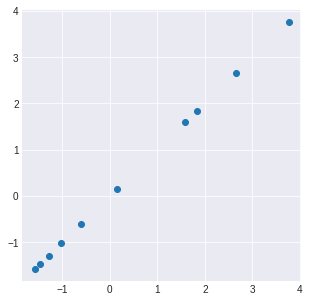

In [13]:
x_star = x_star_theta(np.exp(point['sd_log__']))
point1 = pm.find_MAP(start=point, model=m, vars=[group_mu], progressbar=None)
x_star2 = point1['g_mu']
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x_star, x_star2, 'o');

### Wrap it in theano
ref https://docs.pymc.io/advanced_theano.html

In [14]:
import theano.tests.unittest_tools


class XstarTheta(tt.Op):
    itypes = [tt.dscalar]
    otypes = [tt.dvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        x = x_star_theta(theta)
        outputs[0][0] = np.array(x)

    def grad(self, inputs, g):
        theta, = inputs
        x = self(theta)
        grad_tmp = 2 * x / (number_of_samples * theta**3 * tt.exp(x) + theta)
        return [tt.sum(g[0] * grad_tmp)]

In [15]:
theano.config.compute_test_value = 'off'
theano.tests.unittest_tools.verify_grad(XstarTheta(), [np.array(0.2)])
theano.tests.unittest_tools.verify_grad(XstarTheta(), [np.array(1e-5)])
theano.tests.unittest_tools.verify_grad(XstarTheta(), [np.array(1e5)])

### Put it all togther

```stan
parameters {
  //vector[M] group_mean;
  real<lower=0> sigma;
}
model {
  vector[M] laplace_precisions;
  sigma ~ normal(0,2);
  laplace_precisions = conditional_neg_hessian(conditional_mode, sigma,number_of_samples);
  // p(y | x^*) p(x^* |sigma )/p(x^* | sigma, y)
  for (i in 1:N) {
    target += poisson_log_lpmf(y[i] | conditional_mode[index[i]]);
  }
  target += -0.5*dot_self(conditional_mode)/sigma^2 -M*log(sigma) - 0.5*sum(log(laplace_precisions));
}
generated quantities {
  vector[M] x;
  {
    vector[M] laplace_precisions = conditional_neg_hessian(conditional_mode, sigma,number_of_samples);
    for (i in 1:M) {
      x[i] = normal_rng(conditional_mode[i],inv_sqrt(laplace_precisions[i]));
    }
  }
}
```

In [16]:
tt_XstarTheta = XstarTheta()

with pm.Model() as m_la:
    sd = pm.HalfNormal('sd', 1.)
    conditional_mode = tt_XstarTheta(sd)
    laplace_precisions = conditional_neg_hessian(conditional_mode, sd,
                                                 number_of_samples)
    obs = pm.Poisson('obs', tt.exp(conditional_mode[index]), observed=Y)
    pm.Potential('x∣y,θ',
                 -0.5 * (conditional_mode.dot(conditional_mode)) / sd**2 -
                 M * tt.log(sd) - 0.5 * tt.sum(tt.log(laplace_precisions)))

    group_mu = pm.Deterministic(
        'g_mu',
        pm.tt_rng().normal(1, conditional_mode,
                           1 / tt.sqrt(laplace_precisions)))
    trace_la = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd]
100%|██████████| 2000/2000 [00:10<00:00, 193.16it/s]


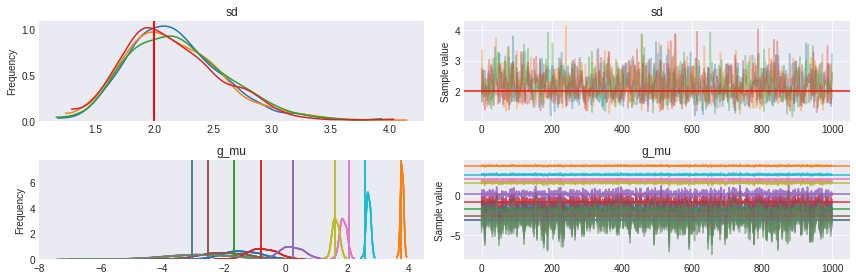

In [17]:
pm.traceplot(trace_la, lines={'sd': sigma, 'g_mu': X});

In [18]:
df_la = pm.summary(trace_la)
df_la.round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sd,2.18,0.42,0.01,1.44,3.00,1704.04,1.0
g_mu__0,-1.45,0.60,0.01,-2.56,-0.25,3855.70,1.0
g_mu__1,3.77,0.05,0.00,3.68,3.88,3871.58,1.0
g_mu__2,-2.78,1.10,0.02,-4.91,-0.66,3730.07,1.0
g_mu__3,-0.76,0.45,0.01,-1.60,0.15,3869.34,1.0
g_mu__4,0.18,0.38,0.00,-0.53,0.94,3871.97,1.0
g_mu__5,-2.01,0.74,0.01,-3.43,-0.56,3827.52,1.0
g_mu__6,1.87,0.12,0.00,1.65,2.11,3871.27,1.0
g_mu__7,-2.92,1.08,0.01,-5.03,-0.85,3721.74,1.0
g_mu__8,1.62,0.12,0.00,1.41,1.86,3871.61,1.0


Compare with MCMC

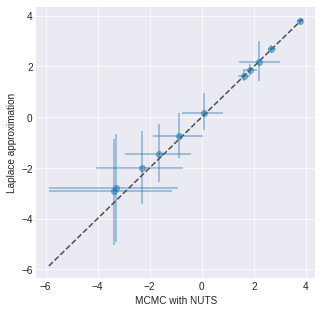

In [19]:
df_nuts = pm.summary(trace)
ind = df_la.index

x = df_nuts['mean'][ind]
xlower = df_nuts['hpd_2.5'][ind]
xupper = df_nuts['hpd_97.5'][ind]

y = df_la['mean'][ind]
ylower = df_la['hpd_2.5'][ind]
yupper = df_la['hpd_97.5'][ind]

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(
    x,
    y,
    yerr=[y - ylower, yupper - y],
    xerr=[x - xlower, xupper - x],
    fmt='o',
    alpha=.5)
ax.set_ylabel('Laplace approximation')
ax.set_xlabel('MCMC with NUTS')
ax.plot(
    [min(xlower), max(xupper)], [min(xlower), max(xupper)], ls="--", c=".3");

### Check with a larger data set

In [20]:
N, M, sigma = 1000, 100, 2.
index2 = np.random.randint(0, M, size=N)
X2 = np.random.normal(0, sigma, size=M)
Y2 = np.random.poisson(np.exp(X2[index2]))

In [21]:
with pm.Model() as m2:
    sd = pm.HalfNormal('sd', 1.)
    group_mu = pm.Normal('g_mu', 0., sd, shape=M)
    obs = pm.Poisson('obs', tt.exp(group_mu[index2]), observed=Y2)
    trace2 = pm.sample(1000, tune=1000)

# transformed data block
sums = np.zeros(M)
number_of_samples = np.zeros(M)
for i in range(N):
    sums[index2[i]] += Y2[i]
    number_of_samples[index2[i]] += 1

# xzero = np.log((sums + 0.1) / number_of_samples)
tmp = M
summm = 0.0
for i in range(M):
    if number_of_samples[i] == 0:
        tmp = tmp - 1
    else:
        summm = summm + sums[i] / number_of_samples[i]

xzero = np.repeat(summm / tmp, M)

with pm.Model() as m_la2:
    sd = pm.HalfNormal('sd', 1.)
    conditional_mode = tt_XstarTheta(sd)
    laplace_precisions = conditional_neg_hessian(conditional_mode, sd,
                                                 number_of_samples)
    obs = pm.Poisson('obs', tt.exp(conditional_mode[index2]), observed=Y2)
    pm.Potential('x∣y,θ',
                 -0.5 * (conditional_mode.dot(conditional_mode)) / sd**2 -
                 M * tt.log(sd) - 0.5 * tt.sum(tt.log(laplace_precisions)))

    group_mu = pm.Deterministic(
        'g_mu',
        pm.tt_rng().normal(1, conditional_mode,
                           1 / tt.sqrt(laplace_precisions)))
    trace_la2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g_mu, sd]
100%|██████████| 2000/2000 [00:17<00:00, 116.29it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd]
100%|██████████| 2000/2000 [01:12<00:00, 27.57it/s]


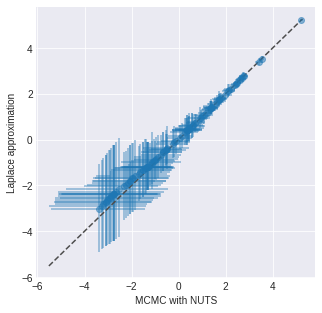

In [22]:
df_nuts = pm.summary(trace2)
df_la = pm.summary(trace_la2)
ind = df_la.index

x = df_nuts['mean'][ind]
xlower = df_nuts['hpd_2.5'][ind]
xupper = df_nuts['hpd_97.5'][ind]

y = df_la['mean'][ind]
ylower = df_la['hpd_2.5'][ind]
yupper = df_la['hpd_97.5'][ind]

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(
    x,
    y,
    yerr=[y - ylower, yupper - y],
    xerr=[x - xlower, xupper - x],
    fmt='o',
    alpha=.5)
ax.set_ylabel('Laplace approximation')
ax.set_xlabel('MCMC with NUTS')
ax.plot(
    [min(xlower), max(xupper)], [min(xlower), max(xupper)], ls="--", c=".3");

## Make it more automatic
Automatically infer the Mode of $p(x \mid y,\theta)$ and the Hessian around the mode

In [23]:
# set up model again following cell above
N, M, sigma = 100, 10, 2.
with pm.Model() as model:
    sd = pm.HalfNormal('sd', 1.)
    group_mu = pm.Normal('g_mu', 0., sd, shape=M)
    obs = pm.Poisson('obs', tt.exp(group_mu[index]), observed=Y)

Q: If I am taking the model likelihood $p (x , \theta \mid y)$ while fix $\theta$ is that the same as taking the mode of $p (x \mid y, \theta)$?

In [24]:
from pymc3.blocking import DictToArrayBijection, ArrayOrdering

start = model.test_point
vars = pm.theanof.inputvars(group_mu)
bij = DictToArrayBijection(ArrayOrdering(vars), start)
logp_func = bij.mapf(model.fastlogp)
x0 = bij.map(start)

dlogp_func = bij.mapf(model.fastdlogp(vars))

In [25]:
dlogp_func(x0)

array([ -8., 341., -10.,  -5.,   1., -10.,  55., -12.,  53., 164.])

In [26]:
# transformed data block
sums = np.zeros(M)
number_of_samples = np.zeros(M)
for i in range(N):
    sums[index[i]] += Y[i]
    number_of_samples[index[i]] += 1

# xzero = np.log((sums + 0.1) / number_of_samples)
tmp = M
summm = 0.0
for i in range(M):
    if number_of_samples[i] == 0:
        tmp = tmp - 1
    else:
        summm = summm + sums[i] / number_of_samples[i]

xzero = np.repeat(summm / tmp, M)

def func(x, sigma):
    return sums - number_of_samples * np.exp(x) - x / sigma**2


# conditional_hessian
def jac(x, sigma):
    return np.diag(-number_of_samples * np.exp(x) - 1 / sigma**2)


def x_star_theta(theta):
    sol = optimize.root(func, np.zeros(M), jac=jac, method='hybr', args=theta)
    return sol.x


func(x0, np.exp(start['sd_log__']))

array([ -8., 341., -10.,  -5.,   1., -10.,  55., -12.,  53., 164.])

In [27]:
dlogp_func_jac = bij.mapf(model.fastd2logp(vars))

In [28]:
dlogp_func_jac(x0)

array([[11.57079633, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  9.57079633, -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , 11.57079633, -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , 10.57079633, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  6.57079633,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        12.57079633, -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , 11.57079633, -0.        

In [29]:
jac(x0, np.exp(start['sd_log__']))

array([[-11.57079633,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -9.57079633,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , -11.57079633,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , -10.57079633,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         -6.57079633,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , -12.57079633,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

Recompiling the dlogp and d2logp is quite slow, ideally we compile it once only

In [30]:
# modify ValueGradFunction from PyMC3
# ValueGradFunction(self.logpt, grad_vars, extra_vars, **kwargs)
class GradHessianFunction(object):
    """Create a theano function that computes a gradient and its Hessian.

    Parameters
    ----------
    cost : theano variable
        The value that we compute with its gradient.
    grad_vars : list of named theano variables
        The arguments with respect to which the gradient is computed.
    extra_vars : list of named theano variables
        Other arguments of the function that are assumed constant. They
        are stored in shared variables and can be set using
        `set_extra_values`.
    dtype : str, default=theano.config.floatX
        The dtype of the arrays.
    casting : {'no', 'equiv', 'save', 'same_kind', 'unsafe'}, default='no'
        Casting rule for casting `grad_args` to the array dtype.
        See `numpy.can_cast` for a description of the options.
        Keep in mind that we cast the variables to the array *and*
        back from the array dtype to the variable dtype.
    kwargs
        Extra arguments are passed on to `theano.function`.

    Attributes
    ----------
    size : int
        The number of elements in the parameter array.
    profile : theano profiling object or None
        The profiling object of the theano function that computes value and
        gradient. This is None unless `profile=True` was set in the
        kwargs.
    """

    def __init__(self,
                 cost,
                 grad_vars,
                 extra_vars=None,
                 dtype=None,
                 casting='no',
                 **kwargs):
        if extra_vars is None:
            extra_vars = []

        names = [arg.name for arg in grad_vars + extra_vars]
        if any(name is None for name in names):
            raise ValueError('Arguments must be named.')
        if len(set(names)) != len(names):
            raise ValueError('Names of the arguments are not unique.')

        if cost.ndim > 0:
            raise ValueError('Cost must be a scalar.')

        self._grad_vars = grad_vars
        self._extra_vars = extra_vars
        self._extra_var_names = set(var.name for var in extra_vars)
        self._cost = cost
        self._ordering = ArrayOrdering(grad_vars)
        self.size = self._ordering.size
        self._extra_are_set = False
        if dtype is None:
            dtype = theano.config.floatX
        self.dtype = dtype
        for var in self._grad_vars:
            if not np.can_cast(var.dtype, self.dtype, casting):
                raise TypeError('Invalid dtype for variable %s. Can not '
                                'cast to %s with casting rule %s.' %
                                (var.name, self.dtype, casting))
            if not np.issubdtype(var.dtype, np.floating):
                raise TypeError('Invalid dtype for variable %s. Must be '
                                'floating point but is %s.' % (var.name,
                                                               var.dtype))

        givens = []
        self._extra_vars_shared = {}
        for var in extra_vars:
            shared = theano.shared(var.tag.test_value, var.name + '_shared__')
            self._extra_vars_shared[var.name] = shared
            givens.append((var, shared))

        self._vars_joined, self._cost_joined = self._build_joined(
            self._cost, grad_vars, self._ordering.vmap)

        grad = tt.grad(self._cost_joined, self._vars_joined)
        grad.name = '__grad'

        f = tt.flatten(grad)
        idx = tt.arange(f.shape[0], dtype='int32')

        def grad_i(i):
            return tt.grad(f[i], self._vars_joined)

        # negative full hessian
        hessian = -theano.map(grad_i, idx)[0]
        hessian.name = '__hessian'

        inputs = [self._vars_joined]

        self._theano_function = theano.function(
            inputs, [grad, hessian], givens=givens, **kwargs)

        self._dlogp_func = theano.function(
            inputs, [grad], givens=givens, **kwargs)

        self._d2logp_func = theano.function(
            inputs, [hessian], givens=givens, **kwargs)

    def set_extra_values(self, extra_vars):
        self._extra_are_set = True
        for var in self._extra_vars:
            self._extra_vars_shared[var.name].set_value(extra_vars[var.name])

    def get_extra_values(self):
        if not self._extra_are_set:
            raise ValueError('Extra values are not set.')

        return {
            var.name: self._extra_vars_shared[var.name].get_value()
            for var in self._extra_vars
        }

    def __call__(self, array, extra_vars=None):
        if extra_vars is not None:
            self.set_extra_values(extra_vars)

        if not self._extra_are_set:
            raise ValueError('Extra values are not set.')

        if array.shape != (self.size, ):
            raise ValueError('Invalid shape for array. Must be %s but is %s.' %
                             ((self.size, ), array.shape))

        dlogp, d2logp = self._theano_function(array)
        return dlogp, d2logp

    def dlogp(self, array, extra_vars=None):
        if extra_vars is not None:
            self.set_extra_values(extra_vars)

        if not self._extra_are_set:
            raise ValueError('Extra values are not set.')

        if array.shape != (self.size, ):
            raise ValueError('Invalid shape for array. Must be %s but is %s.' %
                             ((self.size, ), array.shape))

        return self._dlogp_func(array)[0]
    
    def d2logp(self, array, extra_vars=None):
        if extra_vars is not None:
            self.set_extra_values(extra_vars)

        if not self._extra_are_set:
            raise ValueError('Extra values are not set.')

        if array.shape != (self.size, ):
            raise ValueError('Invalid shape for array. Must be %s but is %s.' %
                             ((self.size, ), array.shape))

        return self._d2logp_func(array)[0]

    @property
    def profile(self):
        """Profiling information of the underlying theano function."""
        return self._theano_function.profile

    def dict_to_array(self, point):
        """Convert a dictionary with values for grad_vars to an array."""
        array = np.empty(self.size, dtype=self.dtype)
        for varmap in self._ordering.vmap:
            array[varmap.slc] = point[varmap.var].ravel().astype(self.dtype)
        return array

    def array_to_dict(self, array):
        """Convert an array to a dictionary containing the grad_vars."""
        if array.shape != (self.size, ):
            raise ValueError('Array should have shape (%s,) but has %s' %
                             (self.size, array.shape))
        if array.dtype != self.dtype:
            raise ValueError(
                'Array has invalid dtype. Should be %s but is %s' %
                (self._dtype, self.dtype))
        point = {}
        for varmap in self._ordering.vmap:
            data = array[varmap.slc].reshape(varmap.shp)
            point[varmap.var] = data.astype(varmap.dtyp)

        return point

    def array_to_full_dict(self, array):
        """Convert an array to a dictionary with grad_vars and extra_vars."""
        point = self.array_to_dict(array)
        for name, var in self._extra_vars_shared.items():
            point[name] = var.get_value()
        return point

    def _build_joined(self, cost, args, vmap):
        args_joined = tt.vector('__args_joined')
        args_joined.tag.test_value = np.zeros(self.size, dtype=self.dtype)

        joined_slices = {}
        for vmap in vmap:
            sliced = args_joined[vmap.slc].reshape(vmap.shp)
            sliced.name = vmap.var
            joined_slices[vmap.var] = sliced

        replace = {var: joined_slices[var.name] for var in args}
        return args_joined, theano.clone(cost, replace=replace)

In [31]:
varnames = [var.name for var in vars]
extra_vars = [var for var in model.free_RVs if var.name not in varnames]
dlogp_d2logp_func = GradHessianFunction(model.logpt, vars, extra_vars)
array0 = dlogp_d2logp_func.dict_to_array(point)

In [32]:
dlogp_d2logp_func.d2logp(array0, point)

array([[11.57079633, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  9.57079633, -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , 11.57079633, -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , 10.57079633, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ,  6.57079633,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        12.57079633, -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , 11.57079633, -0.        

In [33]:
jac(array0, np.exp(point['sd_log__']))

array([[-11.57079633,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -9.57079633,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , -11.57079633,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , -10.57079633,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         -6.57079633,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , -12.57079633,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

In [34]:
def x_star_theta(point):
    sol = optimize.root(
        func,
        np.zeros(M),
        jac=jac,
        method='hybr',
        args=np.exp(point['sd_log__']))
    return sol.x


def dlogp_pm(array, point):
    return dlogp_d2logp_func.dlogp(array, point)


def d2logp_pm(array, point):
    return -dlogp_d2logp_func.d2logp(array, point)


def x_star_theta_pm(point):
    sol = optimize.root(
        dlogp_pm, np.zeros(M), jac=d2logp_pm, method='hybr', args=point)
    return sol.x

In [35]:
%%timeit
thetas = np.linspace(.01, 10, 5)
for theta in thetas:
    point['sd_log__'] = np.log(theta)
    x_star = x_star_theta(point)

1.28 ms ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
%%timeit
thetas = np.linspace(.01, 10, 5)
for theta in thetas:
    point['sd_log__'] = np.log(theta)
    x_star = x_star_theta_pm(point)

15.8 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
x_star_theta(point)

array([-1.60146249,  3.77552219, -5.24960285, -0.80890998,  0.18201815,
       -2.3744285 ,  1.87151421, -5.40310335,  1.62445922,  2.68542475])

In [38]:
x_star_theta_pm(point)

array([-1.60146249,  3.77552219, -5.24960285, -0.80890998,  0.18201815,
       -2.3744285 ,  1.87151421, -5.40310335,  1.62445922,  2.68542475])

In [39]:
Htheta = pm.theanof.hessian(model.logpt, vars)

## An approximation step method that could be combine with `CompoundStep`

In [40]:
from pymc3.step_methods.arraystep import BlockedStep
from pymc3.model import modelcontext


class LaplaceApprox(BlockedStep):
    """
    Step method that approximate a node using Laplace approximation

    Parameters
    ----------
    vars : list
        List of variables to do approximation over.
    model: pymc3 model
    Qtheta: Precision matrix of x: x | theta ~ N(0, Q(theta)^-1)
    """

    def __init__(self, vars, Qtheta, model=None):
        model = modelcontext(model)

        self.vars = vars
        self.m = model

        varnames = [var.name for var in vars]
        extra_vars = [
            var for var in model.free_RVs if var.name not in varnames
        ]
        self._dlogp_d2logp_func = GradHessianFunction(model.logpt, vars,
                                                      extra_vars)

        x_approx = self._dlogp_d2logp_func._vars_joined
        with self.m:
            Htheta = pm.theanof.hessian(self.m.logpt, vars)
            pm.Deterministic(
                'x_approx_sd', 1 / tt.sqrt(tt.diag(Htheta)))

            # I am not sure if Qtheta is really necessary ???? 
            # seems the conditinal Hessian return above is already Q(θ) + H(θ) ????
            
            pm.Potential('x|y,theta',
                         pm.MvNormal.dist(x_approx,
                                          tau=Htheta).logp(x_approx))

#             pm.Potential('x|y,theta',
#                          pm.MvNormal.dist(x_approx,
#                                           tau=Qtheta + Htheta).logp(x_approx))

    def dlogp_pm(self, array, point):
        return self._dlogp_d2logp_func.dlogp(array, point)

    def d2logp_pm(self, array, point):
        return self._dlogp_d2logp_func.d2logp(array, point)

    def x_star_theta_pm(self, point):
        array0 = self._dlogp_d2logp_func.dict_to_array(self.m.test_point)
        sol = optimize.root(
            self.dlogp_pm,
            np.zeros_like(array0), # array0 or a random initial point for the solver
            jac=self.d2logp_pm,
            method='hybr',
            args=point)
        return sol.x

    def step(self, point):
        xmode = self.x_star_theta_pm(point)
        point = self._dlogp_d2logp_func.array_to_full_dict(xmode)
        return point

In [41]:
with pm.Model() as m_la2:
    sd = pm.HalfNormal('sd', 1.)
    group_mu = pm.Normal('g_mu', 0., sd, shape=M)
    obs = pm.Poisson('obs', tt.exp(group_mu[index]), observed=Y)

    step1 = pm.NUTS(vars=[sd])
    step2 = LaplaceApprox(vars=[group_mu], Qtheta=tt.eye(M)*sd**-2)
    trace_la2 = pm.sample(1000, tune=1000, step=[step2, step1])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>LaplaceApprox: [g_mu]
>NUTS: [sd]
100%|██████████| 2000/2000 [00:37<00:00, 53.88it/s]


In [42]:
x_mode = trace_la2['g_mu']
x_mode_sd = trace_la2['x_approx_sd']

g_mu_approx = st.norm.rvs(x_mode, x_mode_sd)

trace_la2.add_values({'g_mu_approx': g_mu_approx})

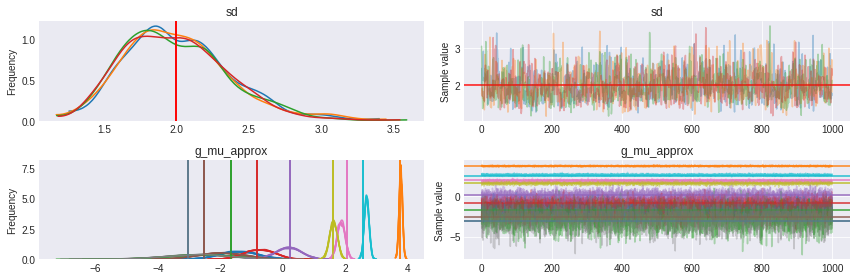

In [43]:
pm.traceplot(
    trace_la2,
    varnames=['sd', 'g_mu_approx'],
    lines={
        'sd': sigma,
        'g_mu_approx': X
    });

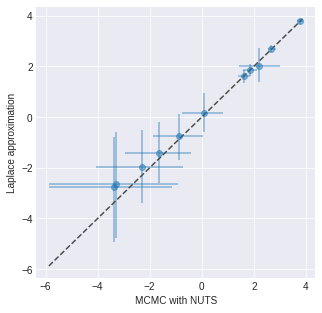

In [44]:
df_1 = pm.summary(trace, varnames=['sd', 'g_mu'])
df_2 = pm.summary(trace_la2, varnames=['sd', 'g_mu_approx'])

x = df_1['mean']
xlower = df_1['hpd_2.5']
xupper = df_1['hpd_97.5']

y = df_2['mean']
ylower = df_2['hpd_2.5']
yupper = df_2['hpd_97.5']

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(
    x,
    y,
    yerr=[y - ylower, yupper - y],
    xerr=[x - xlower, xupper - x],
    fmt='o',
    alpha=.5)
ax.set_ylabel('Laplace approximation')
ax.set_xlabel('MCMC with NUTS')
ax.plot(
    [min(xlower), max(xupper)], [min(xlower), max(xupper)], ls="--", c=".3");

## Another example

In [52]:
N, M, sigma = 500, 20, 3.5
index = np.random.randint(0, M, size=N)
X = np.random.normal(0, sigma, size=M)
Y = np.random.poisson(np.exp(X[index]))

In [53]:
with pm.Model() as m_la2:
    sd = pm.HalfNormal('sd', 2.)
    group_mu = pm.Normal('g_mu', 0, sd, shape=M)
    obs = pm.Poisson('obs', tt.exp(group_mu[index]), observed=Y)

    step1 = pm.NUTS(vars=[sd])
    step2 = LaplaceApprox(vars=[group_mu], Qtheta=tt.eye(M)*sd**-2)
    trace_la2 = pm.sample(1000, tune=1000, step=[step2, step1])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>LaplaceApprox: [g_mu]
>NUTS: [sd]
100%|██████████| 2000/2000 [01:15<00:00, 26.37it/s]
The acceptance probability does not match the target. It is 0.8952208695996767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831100277178242, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


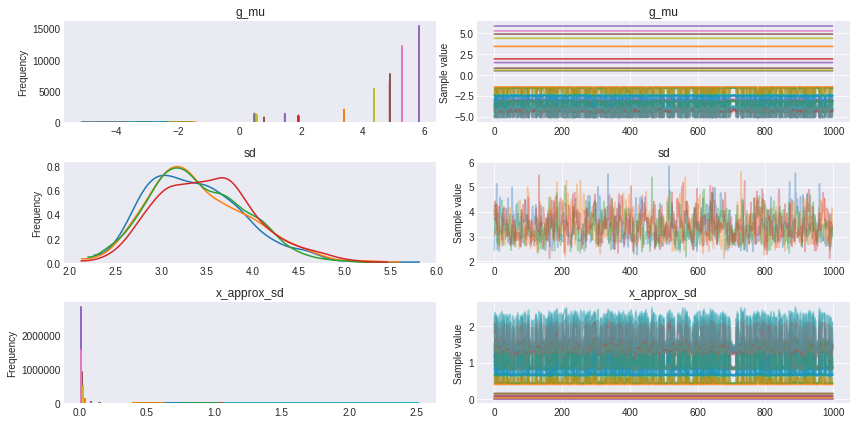

In [54]:
pm.traceplot(trace_la2);

In [55]:
x_mode = trace_la2['g_mu']
x_mode_sd = trace_la2['x_approx_sd']

g_mu_approx = st.norm.rvs(x_mode, x_mode_sd)

trace_la2.add_values({'g_mu_approx': g_mu_approx})

In [56]:
with pm.Model() as m:
    sd = pm.HalfNormal('sd', 2.)
    group_mu = pm.Normal('g_mu', 0, sd, shape=M)
    obs = pm.Poisson('obs', tt.exp(group_mu[index]), observed=Y)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g_mu, sd]
100%|██████████| 2000/2000 [00:12<00:00, 161.73it/s]


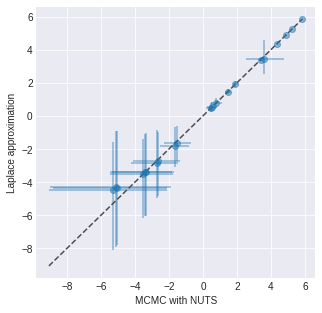

In [57]:
df_1 = pm.summary(trace, varnames=['sd', 'g_mu'])
df_2 = pm.summary(trace_la2, varnames=['sd', 'g_mu_approx'])

x = df_1['mean']
xlower = df_1['hpd_2.5']
xupper = df_1['hpd_97.5']

y = df_2['mean']
ylower = df_2['hpd_2.5']
yupper = df_2['hpd_97.5']

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(
    x,
    y,
    yerr=[y - ylower, yupper - y],
    xerr=[x - xlower, xupper - x],
    fmt='o',
    alpha=.5)
ax.set_ylabel('Laplace approximation')
ax.set_xlabel('MCMC with NUTS')
ax.plot(
    [min(xlower), max(xupper)], [min(xlower), max(xupper)], ls="--", c=".3");

## Next step: INLA

- Blog posts and tutorials
    - http://www.flutterbys.com.au/stats/tut/tut12.9.html
    - https://www.precision-analytics.ca/blog-1/inla
    - http://www.martinmodrak.cz/2018/02/02/a-gentle-stan-vs.-inla-comparison/
- References
    - http://www.statslab.cam.ac.uk/~rjs57/RSS/0708/Rue08.pdf
    - https://arxiv.org/pdf/1604.00860.pdf
    - https://arxiv.org/pdf/1403.4630.pdf
    - https://arxiv.org/pdf/1503.00256.pdf